In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

In [2]:
dataset='bone_tumor'

from data.loader import DataLoader
dl = DataLoader()
primitive_matrix, ground = dl.load_data(dataset=dataset)

In [3]:
#TODO formalize
train_primitive_matrix = primitive_matrix[0:400,:]
train_ground = ground[0:400]

val_primitive_matrix = primitive_matrix[400:600,:]
val_ground = ground[400:600]

## Synthesis + Verification
Generate functions based on feedback from the verifier (vary cardinality)

In [4]:
from program_synthesis.heuristic_generator import HeuristicGenerator

program_synthesis/synthesizer.py:110: RuntimeWarning: invalid value encountered in divide
  accuracies = np.mean(L.T == self.val_ground, axis=1)/coverages


Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2
Inferred cardinality: 2


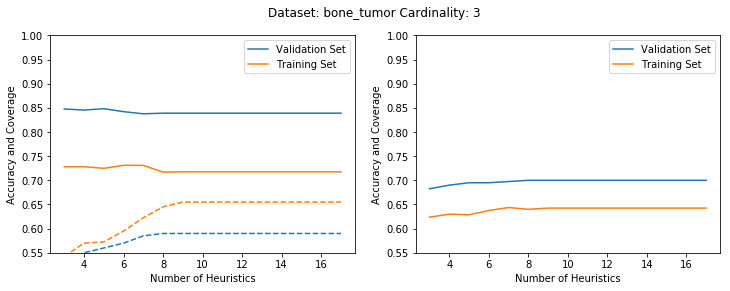

In [5]:
c = 3
validation_accuracy = []
training_accuracy = []
validation_coverage = []
training_coverage = []
idx = None

hg = HeuristicGenerator(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground, 
                            b=0.6, beta=0.2, gamma=0.35)
for i in range(3,18):
    if i == 3:
        hg.run_synthesizer(cardinality=c, idx=idx, keep=3)
    else:
        hg.run_synthesizer(cardinality=c, idx=idx, keep=1)
    hg.run_verifier()
    
    va,ta, vc, tc = hg.evaluate()
    validation_accuracy.append(va)
    training_accuracy.append(ta)
    validation_coverage.append(vc)
    training_coverage.append(tc)
    
    hg.find_feedback()
    idx = hg.feedback_idx    
    


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(range(3,18),validation_accuracy, color='C0')
plt.plot(range(3,18),training_accuracy, color='C1')
plt.plot(range(3,18),validation_coverage, color='C0', linestyle='--')
plt.plot(range(3,18),training_coverage, color='C1', linestyle='--')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
plt.ylim([0.55,1.0])

plt.subplot(1,2,2)
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(validation_accuracy,validation_coverage)] 
plt.plot(range(3,18),bm, color='C0')
bm = [(a*b) + (0.5*(1-b)) for a,b in zip(training_accuracy,training_coverage)] 
plt.plot(range(3,18),bm, color='C1')
plt.legend(['Validation Set', 'Training Set'])
plt.xlabel('Number of Heuristics')
plt.ylabel('Accuracy and Coverage')
plt.ylim([0.55,1.0])
plt.suptitle('Dataset: ' + dataset + ' Cardinality: ' + str(c))

## Calculate Baselines

[**Decision Tree**](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
Depth bound is the number of primitives, using default settings. Could do a finer comparison if needed.

In [43]:
from baselines.decision_tree import DecisionTree
dt = DecisionTree(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
dt.fit()
va,ta, vc, tc = dt.evaluate()
print "Decision Tree Train Accuracy: ", ta
print "Decision Tree Validation Accuracy: ", va

Decision Tree Train Accuracy:  0.6275
Decision Tree Validation Accuracy:  1.0


[**Boosting (AdaBoost)**](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) No bound of the number of estimators yet, could bound by number of primitives for "fair" comparison?

In [46]:
from baselines.boosting import BoostClassifier
bc = BoostClassifier(train_primitive_matrix, val_primitive_matrix, 
                            val_ground, train_ground)
bc.fit()
va,ta, vc, tc = bc.evaluate()
print "Boosting Train Accuracy: ", ta
print "Boosting Validation Accuracy: ", va

Boosting Train Accuracy:  0.6025
Boosting Validation Accuracy:  0.99


np.max(bm